# Лабораторная работа 6. 
# Прогнозирование стоимости акций с помощью линейной регрессии

В данной работе вам необходимо построить регрессионную модель для прогноза стоимости акций 
- для дат, находящихся в рассматриваемом временном периоде
- для дат после некоторого временного периода (т.е. на будущее)

Для построения модели линейной регрессии и оценки ее качества вы будете использовать инструменты из пакета `scikit-learn` -  пользуйтесь руководством пользователя https://scikit-learn.org/stable/user_guide.html  для этого пакета.

В датасете представлена информация о торгах по акциям британской кинокомпании Seven Arts Entertainment Inc:
- Дата торгов (Date)
- Цена открытия (Open)
- Цена закрытия (Close)
- Наибольшая цена (High)
- Наименьшая цена (Low)
- Торговый объем (Traded Volume)
- Оборот (Turnover)

Необходимо постороить регрессию цены закрытия на время.

## Загрузка данных

### Импорт библиотек

In [94]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'axes.facecolor': '#EAEAF2',
    'axes.edgecolor': 'white',
    'axes.linewidth': 0,
    'axes.grid': True,
    'axes.axisbelow': True,
    'grid.color': 'white',
    'grid.linewidth': 1,
    'figure.facecolor': 'white',
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'axes.spines.right': False,
    'axes.spines.top': False
})
plt.rc('figure', figsize=(16,10))
plt.rc('lines', markersize=4)

📌📌📌 **Задание 1**

Загрузите таблицу данных из файла (`sap_stock_1.csv` - для варианта 1,`sap_stock_4.csv` - для варианта 2,`sap_stock_4.csv` - для варианта 3,`sap_stock_4.csv` - для варианта 4).

Выведите на экран несколько первых строк датасета.
С помощью `pd.info()` и `pd.describe()` выведите информацию о структуре датасета и описательные статистики для каждой из переменных

In [95]:
# Ваш код
data = pd.read_csv('sap_stock_4.csv',sep=',')
print(data.head())
print('info')
print(data.info())
print('describe')
print(data.describe())

         Date   Open   High    Low  Close  Change  Traded Volume     Turnover  \
0  2017-01-02  81.99  83.57  81.68  83.54     NaN      1121699.0   93099042.0   
1  2017-01-03  83.74  83.74  82.73  82.89     NaN      1801855.0  149692483.0   
2  2017-01-04  82.98  83.26  81.72  82.43     NaN      2067356.0  170153603.0   
3  2017-01-05  82.23  82.69  81.85  82.69     NaN      1617422.0  133307428.0   
4  2017-01-06  82.70  83.66  82.49  83.66     NaN      1890644.0  157500554.0   

   Last Price of the Day  Daily Traded Units  Daily Turnover  
0                    NaN                 NaN             NaN  
1                    NaN                 NaN             NaN  
2                    NaN                 NaN             NaN  
3                    NaN                 NaN             NaN  
4                    NaN                 NaN             NaN  
info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 11 columns):
 #   Column              

📌📌📌 **Задание 2**

Сформируйте датасет `df`, по которому будет строиться и оцениваться модель регрессии.
Датасет должен содержать:
- столбец значений переменной-отклика `Сlose`, 
- столбец значений переменной `Date` (который мы не будем включать в модель, а используем только для визуализации)

Индексы датасета - номера моментов времени. Их вы будете использовать в качестве единственного предиктора. 

In [96]:
# Ваш код
df = data[['Date','Close']]
df.describe()

,Close
count,985.000000
mean,103.274152
std,14.776348
min,82.430000
25%,91.660000
50%,98.940000
75%,113.180000
max,142.340000


## Предварительный визуальный анализ данных

Построим график зависимости *цены акции* от *времени*. Убедимся, что несмотря на многочисленные колебания цены имеетя тренд на рост цены. Возможно, этот тренд можно приблизить линейной функцией.

In [97]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

C:\Users\dpomi\AppData\Local\Temp\ipykernel_26416\2460778929.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')


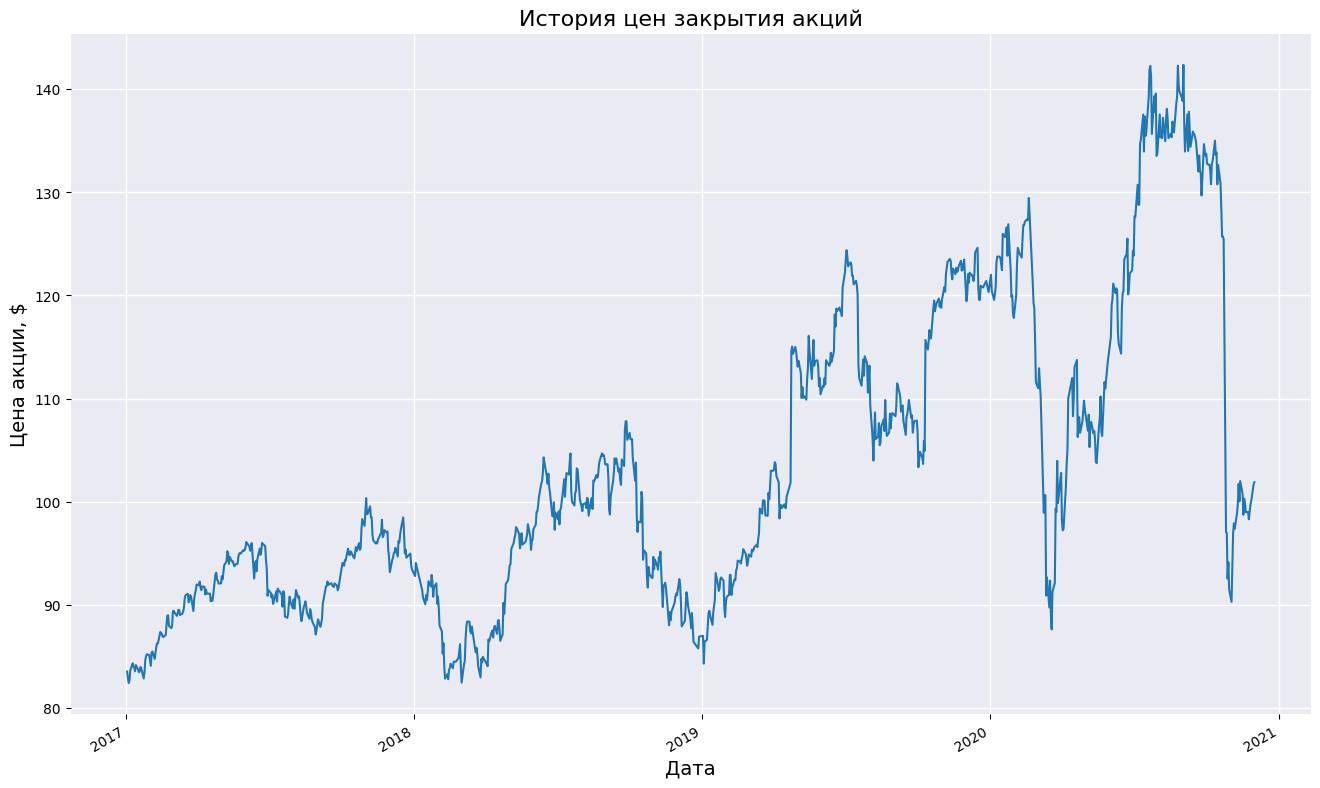

In [98]:
# Подключение модуля matplotlib для графиков с датами
import matplotlib.dates as mdates

years = mdates.YearLocator() # Извлекать из даты будем только год
yearsFmt = mdates.DateFormatter('%Y') # Формат представления года

# Create subplots to plot graph and control axes
fig, ax = plt.subplots()
ax.plot(df['Date'], df['Close'])

# Format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

# Set figure title
plt.title('История цен закрытия акций', fontsize=16)
# Set x label
plt.xlabel('Дата', fontsize=14)
# Set y label
plt.ylabel('Цена акции, $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

## Обучение модели парной линейной регрессии
 
Наша цель - обучение модели линейной регрессии вида
$$
Y = \beta_0 + \beta_1 X
$$

где   
* $Y$  - отклик (цена акции)
* $X$  - независимая переменная (момент времени)
* $\beta_0$, $\beta_1$ коэффициенты регрессии

Обучение регрессии состоит в подборе таких $\beta_0$ и $\beta_1$ , чтобы  **Сумма квадратов отклонений (RSS)** была минимальна.

📌📌📌 **Задание 3**

Разделите датасет `df` на тренировочный (`train`) и тестовый (`test`) в соотношении 80:20.

В датасет `X_train` отделите информацию о значениях предиктора  *момент времени* из датасета `train`(он находится в индексе), в 
`y_train` - значения отклика *цена* из датасета `train`.

Аналогично создайте `X_test` и `y_test`.

Обучите линейную регрессию на `(X_train, y_train)`

Вычислите значение коэффициента детерминации полученной модели на тренировочном датасете.

Хорошо ли линейная регрессия объясняет дисперсию отклика на обучающей выборке?

In [99]:
# импорт модуля для случайного разделения выборок 
from sklearn.model_selection import train_test_split

In [100]:
# Ваш код - разделение выборки
X = df.index.values.reshape(-1, 1)
y = df['Close'].values

# Разделение на train/test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [101]:
# импорт линейного регрессора из модуля, содержащего различные линейные модели
from sklearn.linear_model import LinearRegression

In [102]:
# Ваш код - обучение линейной модели
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [103]:
#Вычисляем R^2 на обучающей выборке
model.score(X_train, y_train)

0.5940067537138697

### Изобразим линию регрессии

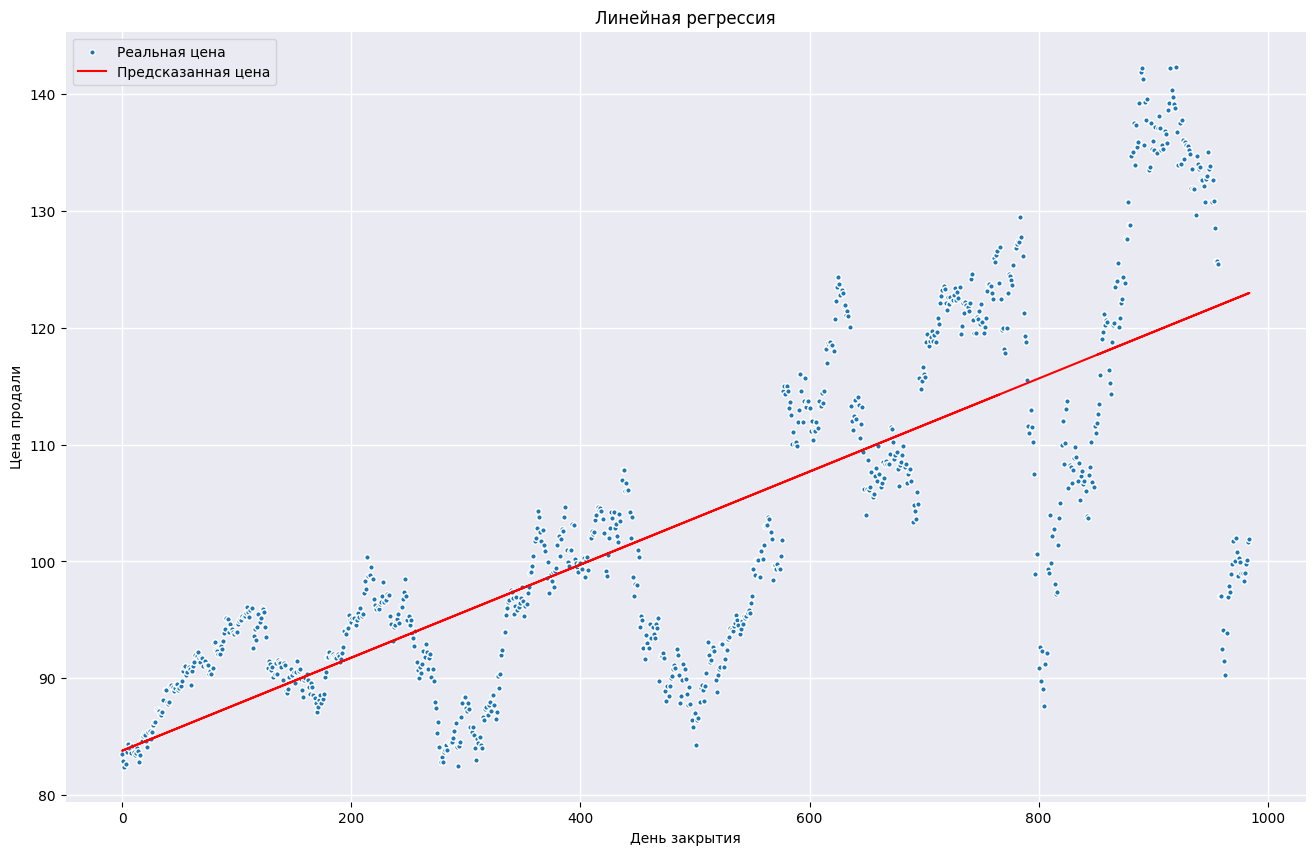

In [104]:
plt.figure(1, figsize=(16,10))
plt.title('Линейная регрессия')
plt.scatter(X, y, edgecolor='w', label='Реальная цена')
plt.plot(X_train, model.predict(X_train), color='r', label='Предсказанная цена')
plt.xlabel('День закрытия')
plt.ylabel('Цена продали')
plt.legend()
plt.show()

## Оценка модели регрессии
**Метрики ошибки:**

   **Mean Squared Error (MSE)** - среднеквадратичная ошибка:
    $$
    \frac{1}{N} \sum_{i = 1}^{N} (y_i - \hat{y}_i)^2
    $$

   **Root Mean Squared Error (RMSE)** - корень из среднеквадратичной ошибки:
    $$
    \sqrt{\frac{1}{N} \sum_{i = 1}^{N} (y_i - \hat{y}_i)^2}
    $$

Это те метрики, которые необходимо минимизировать.

**Метрики качества:**

   **Coefficient of determination** - коэффициент детерминации (измеряет, насколько хорошо общая дисперсия отклика объясняется моделью регрессии):
    $$
    R^2 = 1 - \frac{RSS}{TSS}
    $$

   где

   **Residual Sum of Squares (RSS)** - сумма квадратов регрессионных остатков
    $$
    RSS = \sum_{i = 1}^{N} \epsilon_i^2 = \sum_{i = 1}^{N} (y_i - \hat{y}_i)^2
    $$

   **Total Sum of Squares (TSS)**  - общая сумма квадратов отклонений от среднего значения
    $$
    TSS = \sum_{i = 1}^{N} (y_i - \bar{y}_i)^2
    $$

$R^2$ - метрика, которую необходимо максимизировать.

📌📌📌 **Задание 4**

С помощью полученной вами модели регрессии постройте прогноз на тестовой выборке (используйте функцию `LinearRegression.predict()`).


На тестовой выборке вычислите значения метрик **MSE**, **RMSE**, **$R^2$** (используйте функции  `metrics.mean_squared_error()` и `metrics.r2_score()` )

По аналогии с предыдущим заданием, изобразите линию регрессии вместе с точками данных из тестовой выборки.

Как вы оцениваете качество регрессионной модели на тестовой выборке?

In [105]:
# импортируем из sklearn модуль, содержащие метрики качества
from sklearn import metrics

MSE: 76.9594
RMSE: 8.7726
R^2: 0.6172


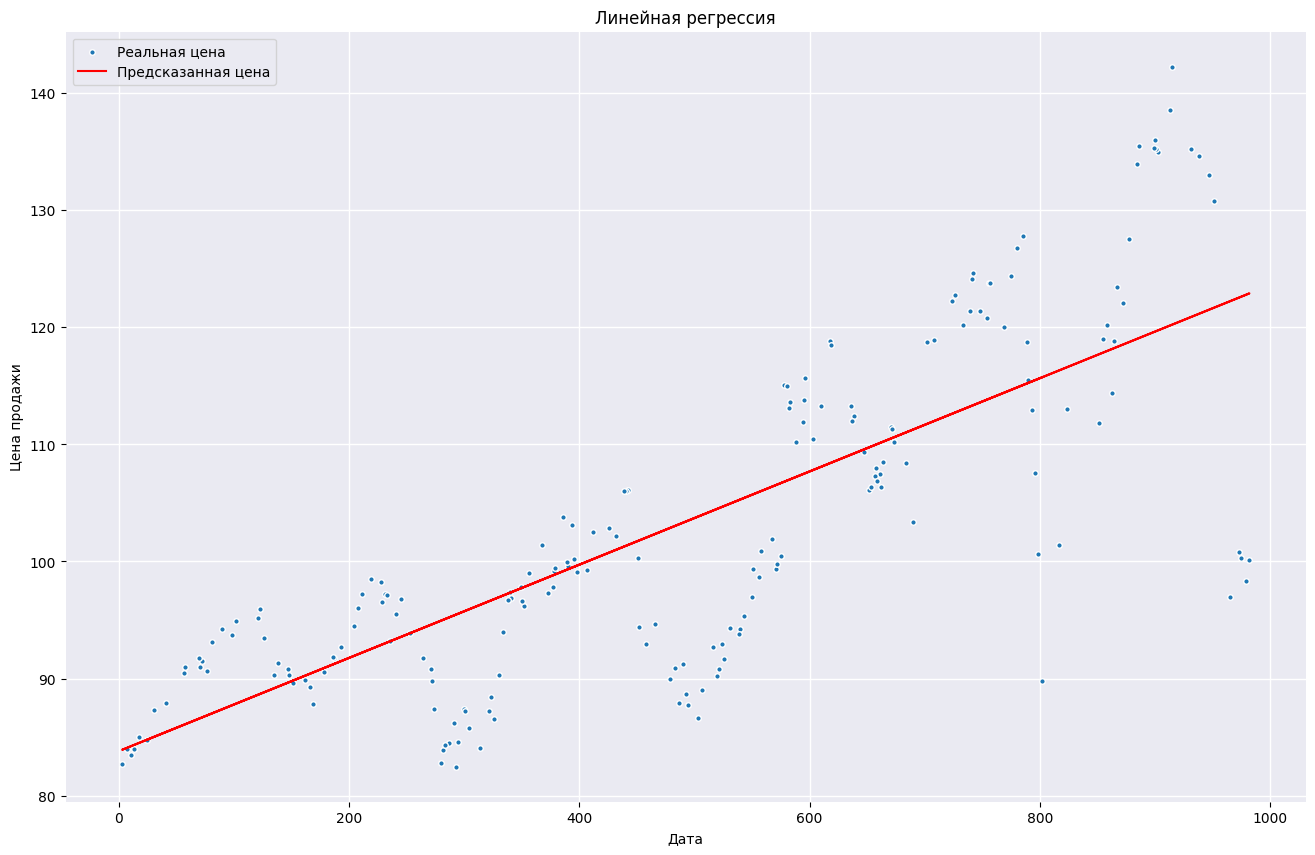

In [106]:
# Ваш код
# Задание 4: Оценка модели на тестовой выборке
y_pred = model.predict(X_test)

# Метрики качества
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")

# Визуализация на тестовой выборке
plt.figure(figsize=(16,10))
plt.title('Линейная регрессия')
plt.scatter(X_test, y_test, edgecolor='w', label='Реальная цена')
plt.plot(X_test, y_pred, color='r', label='Предсказанная цена')
plt.xlabel('Дата')
plt.ylabel('Цена продажи')
plt.legend()
plt.show()

📌📌📌 **Задание 5**

Теперь обучите линейную регрессионную модель и оцените ее качество, по-другому разбив датасет на тренировочный и тестовый.
Разбивать необходимо также в соотношении 80:20, но не случайным образом, а поместив в обучающую выборку первые 80% объектов, а в тестовую - последние 20%.

В ячейках ниже напишите код, который:
1. Разбивает датасет `df` на новые тренировочный и тестовый датасеты.
2. Обучает модель регрессии и на тренировочном датасете вычисляет значение $R^2$
3. Строит прогноз на тестовом датасете и вычисляет на нем метрики **MSE**, **RMSE**, **$R^2$**
4. На одном графике отображает объекты тренировочного и тестового датасета и линию регрессии.

Как вам качество регрессии: стало лучше или хуже по сравнению со случаем случайного разбиения на тренировочный и тестовый датасеты? Как думаете, почему?

MSE (упоряд): 239.8460
RMSE (упоряд): 15.4870
R^2 (упоряд): 0.0526


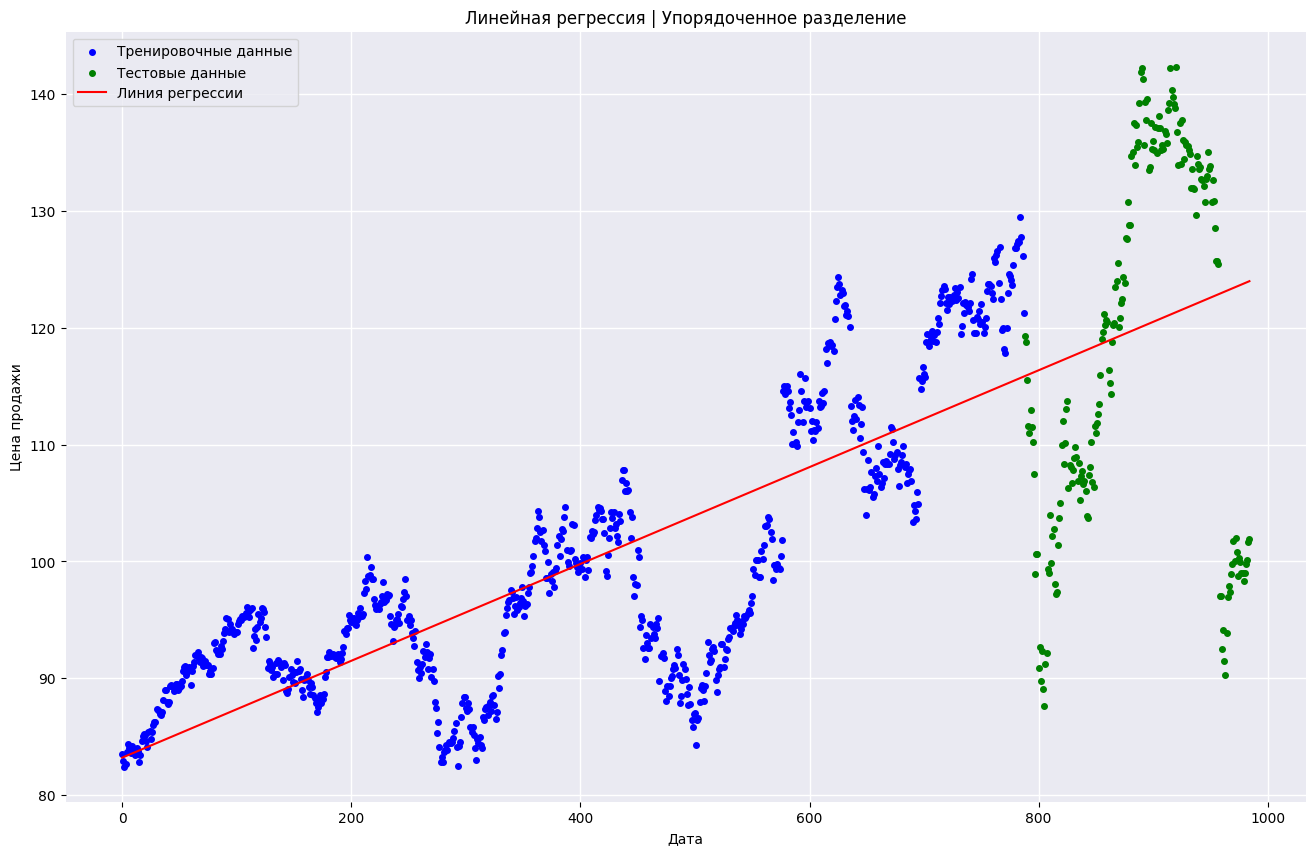

In [107]:
# Ваш код
# Задание 5: Разделение по порядку (первые 80% / последние 20%)
split_index = int(0.8 * len(df))
X_train_ordered = X[:split_index]
X_test_ordered = X[split_index:]
y_train_ordered = y[:split_index]
y_test_ordered = y[split_index:]

# Обучение модели
model_ordered = LinearRegression()
model_ordered.fit(X_train_ordered, y_train_ordered)

# Прогноз и оценка
y_pred_ordered = model_ordered.predict(X_test_ordered)

mse_ordered = metrics.mean_squared_error(y_test_ordered, y_pred_ordered)
rmse_ordered = np.sqrt(mse_ordered)
r2_ordered = metrics.r2_score(y_test_ordered, y_pred_ordered)

print(f"MSE (упоряд): {mse_ordered:.4f}")
print(f"RMSE (упоряд): {rmse_ordered:.4f}")
print(f"R^2 (упоряд): {r2_ordered:.4f}")

# Визуализация
plt.figure(figsize=(16,10))
plt.title('Линейная регрессия | Упорядоченное разделение')
plt.scatter(X_train_ordered, y_train_ordered, color='blue', label='Тренировочные данные')
plt.scatter(X_test_ordered, y_test_ordered, color='green', label='Тестовые данные')
plt.plot(X, model_ordered.predict(X), color='red', label='Линия регрессии')
plt.xlabel('Дата')
plt.ylabel('Цена продажи')
plt.legend()
plt.show()

## Квазилинейная регрессия

В случае, если линейная модель плохо объясняет дисперсию отклика, можно использовать обощение линейной модели - квазилинейную регрессию, в которую предикторы входят нелинейным образом.

Например, если в $f(x)$ кроме тренда присутствуют циклические колебания значений отклика, можно попробовать использовать в качестве предикторов не только $x$, но и элементы тригонометрического ряда Фурье функции $f(x)$: $$\sin\left(\frac{2 n\pi}{w} \cdot x\right) \text{ и } \cos\left(\frac{2 n\pi }{w} \cdot x\right),$$
гдe $w$ - период колебаний, значения $n=1,2,3...w$ 

📌📌📌 **Задание 6 (только для варианта 4)**

В датасет `df` добавьте столбцы со значениями предикторов, полученных как элементы ряда Фурье, где переменная $x$ - момент времени из `df.index`, период колебаний $w$ подберите по графикам выше. 

Число элементов ряда Фурье выберите самостоятельно (начните с $n=\{1, 2\}$, затем увеличивайте число элементов, пока качество регрессии продолжает существенно улучшаться)

Повторите работу, проведенную вами в задании 3 и задании 4.

Сравните качество линейной и квазилинейной регрессии. Удалось ли улучшить качество линейной модели добавлением нелинейных предикторов? 


In [108]:
# Ваш код
t = df.index
df['time'] = t
w = 250  # период колебаний (подобран по графику)

# Создаем n гармоник
num_harmonics = 6
for i in range(1, num_harmonics + 1):
    sin_col = f"sin_{i}"
    cos_col = f"cos_{i}"
    df[sin_col] = np.sin(2 * i * np.pi * t / w)
    df[cos_col] = np.cos(2 * i * np.pi * t / w)

# Формируем матрицу признаков (исключаем исходные столбцы с датами)
feature_cols = ['time'] + [f"sin_{i}" for i in range(1, num_harmonics + 1)] + [f"cos_{i}" for i in range(1, num_harmonics + 1)]
X_quasi = df[feature_cols]

# Модель 1: Обычное разделение
X_train_quasi, X_test_quasi, y_train_quasi, y_test_quasi = train_test_split(
    X_quasi, y, test_size=0.2
)

model_quasi = LinearRegression()
model_quasi.fit(X_train_quasi, y_train_quasi)

# Прогноз и оценка для случайного разделения
y_pred_quasi = model_quasi.predict(X_test_quasi)
mse_quasi = metrics.mean_squared_error(y_test_quasi, y_pred_quasi)
rmse_quasi = np.sqrt(mse_quasi)
r2_quasi = metrics.r2_score(y_test_quasi, y_pred_quasi)

print("=== Квазилинейная регрессия (случайное разделение) ===")
print(f"MSE: {mse_quasi:.4f}")
print(f"RMSE: {rmse_quasi:.4f}")
print(f"R²: {r2_quasi:.4f}")

# Модель 2: Последовательное разделение
split_index = int(0.8 * len(df))
X_train_quasi_ord = X_quasi.iloc[:split_index]
X_test_quasi_ord = X_quasi.iloc[split_index:]
y_train_quasi_ord = y[:split_index]
y_test_quasi_ord = y[split_index:]

model_quasi_ord = LinearRegression()
model_quasi_ord.fit(X_train_quasi_ord, y_train_quasi_ord)

# Прогноз и оценка для последовательного разделения
y_pred_quasi_ord = model_quasi_ord.predict(X_test_quasi_ord)
mse_quasi_ord = metrics.mean_squared_error(y_test_quasi_ord, y_pred_quasi_ord)
rmse_quasi_ord = np.sqrt(mse_quasi_ord)
r2_quasi_ord = metrics.r2_score(y_test_quasi_ord, y_pred_quasi_ord)

print("\n=== Квазилинейная регрессия (последовательное разделение) ===")
print(f"MSE: {mse_quasi_ord:.4f}")
print(f"RMSE: {rmse_quasi_ord:.4f}")
print(f"R²: {r2_quasi_ord:.4f}")

# Сравнение с базовой линейной моделью
print("\n=== Сравнение с линейной моделью ===")
print(f"Линейная модель (случайное разделение) R²: {model.score(X_test, y_test):.4f}")
print(f"Линейная модель (последовательное разделение) R²: {r2_ordered:.4f}")

=== Квазилинейная регрессия (случайное разделение) ===
MSE: 74.4654
RMSE: 8.6293
R²: 0.6815

=== Квазилинейная регрессия (последовательное разделение) ===
MSE: 230.7861
RMSE: 15.1916
R²: 0.0884

=== Сравнение с линейной моделью ===
Линейная модель (случайное разделение) R²: 0.6172
Линейная модель (последовательное разделение) R²: 0.0526


C:\Users\dpomi\AppData\Local\Temp\ipykernel_26416\1099773999.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = t
C:\Users\dpomi\AppData\Local\Temp\ipykernel_26416\1099773999.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sin_col] = np.sin(2 * i * np.pi * t / w)
C:\Users\dpomi\AppData\Local\Temp\ipykernel_26416\1099773999.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

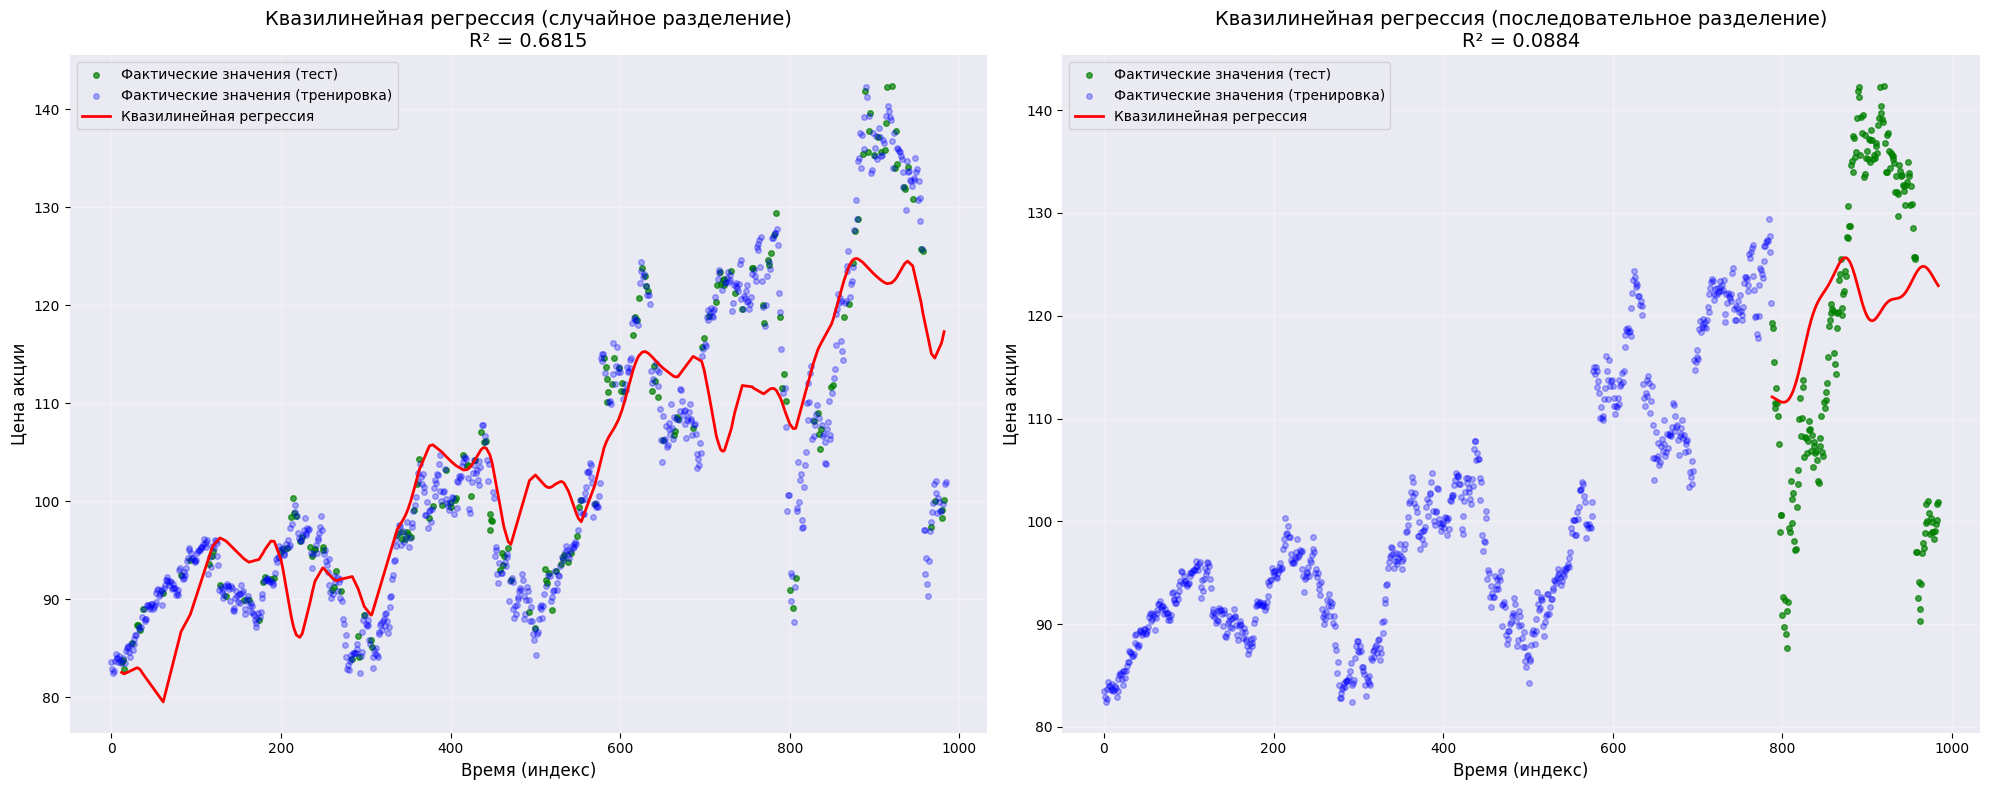

Сравнение моделей:
                             Модель      R²       MSE     RMSE
0              Линейная (случайное)  0.6172   76.9594   8.7726
1       Линейная (последовательное)  0.0526  239.8460  15.4870
2         Квазилинейная (случайное)  0.6815   74.4654   8.6293
3  Квазилинейная (последовательное)  0.0884  230.7861  15.1916


In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# График 1: Случайное разделение
ax1.scatter(X_test_quasi['time'], y_test_quasi, alpha=0.7, color='green', label='Фактические значения (тест)')
ax1.scatter(X_train_quasi['time'], y_train_quasi, alpha=0.3, color='blue', label='Фактические значения (тренировка)')

# Сортируем по времени для графика линии регрессии
time_sorted_idx = np.argsort(X_test_quasi['time'])
time_sorted = X_test_quasi['time'].iloc[time_sorted_idx].values
test_sorted = X_test_quasi.iloc[time_sorted_idx]
y_pred_sorted = model_quasi.predict(test_sorted)

ax1.plot(time_sorted, y_pred_sorted, color='red', linewidth=2, label='Квазилинейная регрессия')
ax1.set_title(f'Квазилинейная регрессия (случайное разделение)\nR² = {r2_quasi:.4f}', fontsize=14)
ax1.set_xlabel('Время (индекс)', fontsize=12)
ax1.set_ylabel('Цена акции', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# График 2: Последовательное разделение
ax2.scatter(X_test_quasi_ord['time'], y_test_quasi_ord, alpha=0.7, color='green', label='Фактические значения (тест)')
ax2.scatter(X_train_quasi_ord['time'], y_train_quasi_ord, alpha=0.3, color='blue', label='Фактические значения (тренировка)')

# Для последовательного разделения данные уже упорядочены
time_ord = X_test_quasi_ord['time']
ax2.plot(time_ord, y_pred_quasi_ord, color='red', linewidth=2, label='Квазилинейная регрессия')
ax2.set_title(f'Квазилинейная регрессия (последовательное разделение)\nR² = {r2_quasi_ord:.4f}', fontsize=14)
ax2.set_xlabel('Время (индекс)', fontsize=12)
ax2.set_ylabel('Цена акции', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

metrics_summary = pd.DataFrame({
    'Модель': ['Линейная (случайное)', 'Линейная (последовательное)', 
               'Квазилинейная (случайное)', 'Квазилинейная (последовательное)'],
    'R²': [model.score(X_test, y_test), r2_ordered, r2_quasi, r2_quasi_ord],
    'MSE': [metrics.mean_squared_error(y_test, model.predict(X_test)), 
            mse_ordered, mse_quasi, mse_quasi_ord],
    'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, model.predict(X_test))), 
             rmse_ordered, rmse_quasi, rmse_quasi_ord]
})

print("Сравнение моделей:")
print(metrics_summary.round(4))

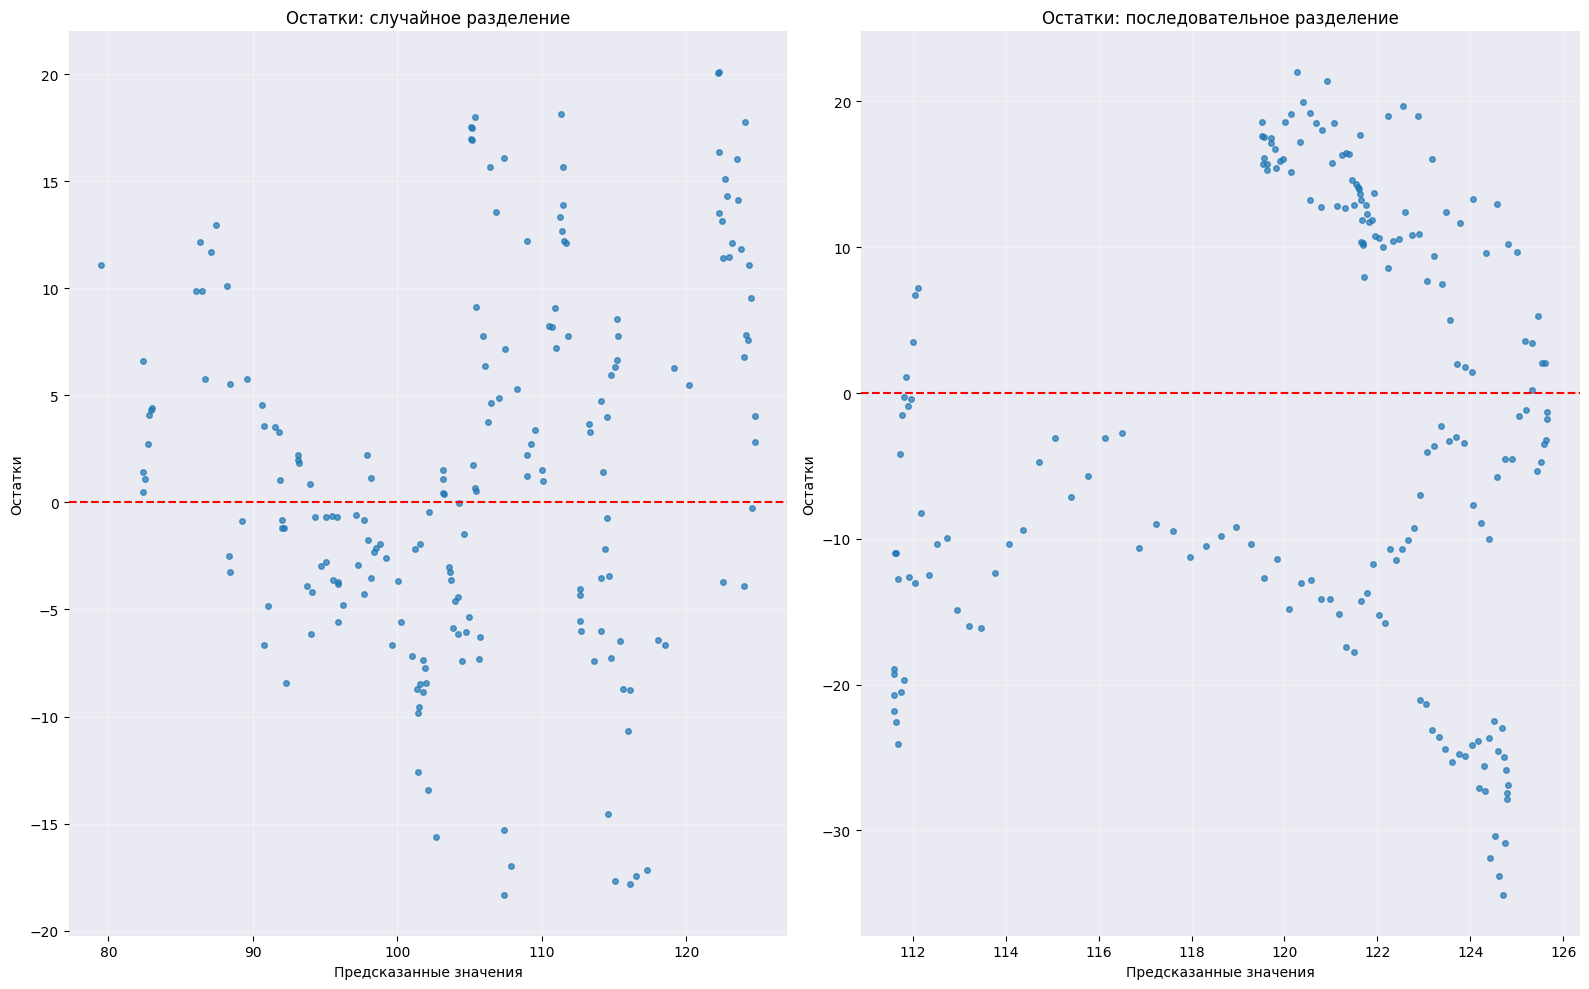

In [110]:
# для случайного
plt.subplot(1, 2, 1)
residuals_random = y_test_quasi - y_pred_quasi
plt.scatter(y_pred_quasi, residuals_random, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Остатки: случайное разделение')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.grid(True, alpha=0.3)

#для последовательного разделения
plt.subplot(1, 2, 2)
residuals_ordered = y_test_quasi_ord - y_pred_quasi_ord
plt.scatter(y_pred_quasi_ord, residuals_ordered, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Остатки: последовательное разделение')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

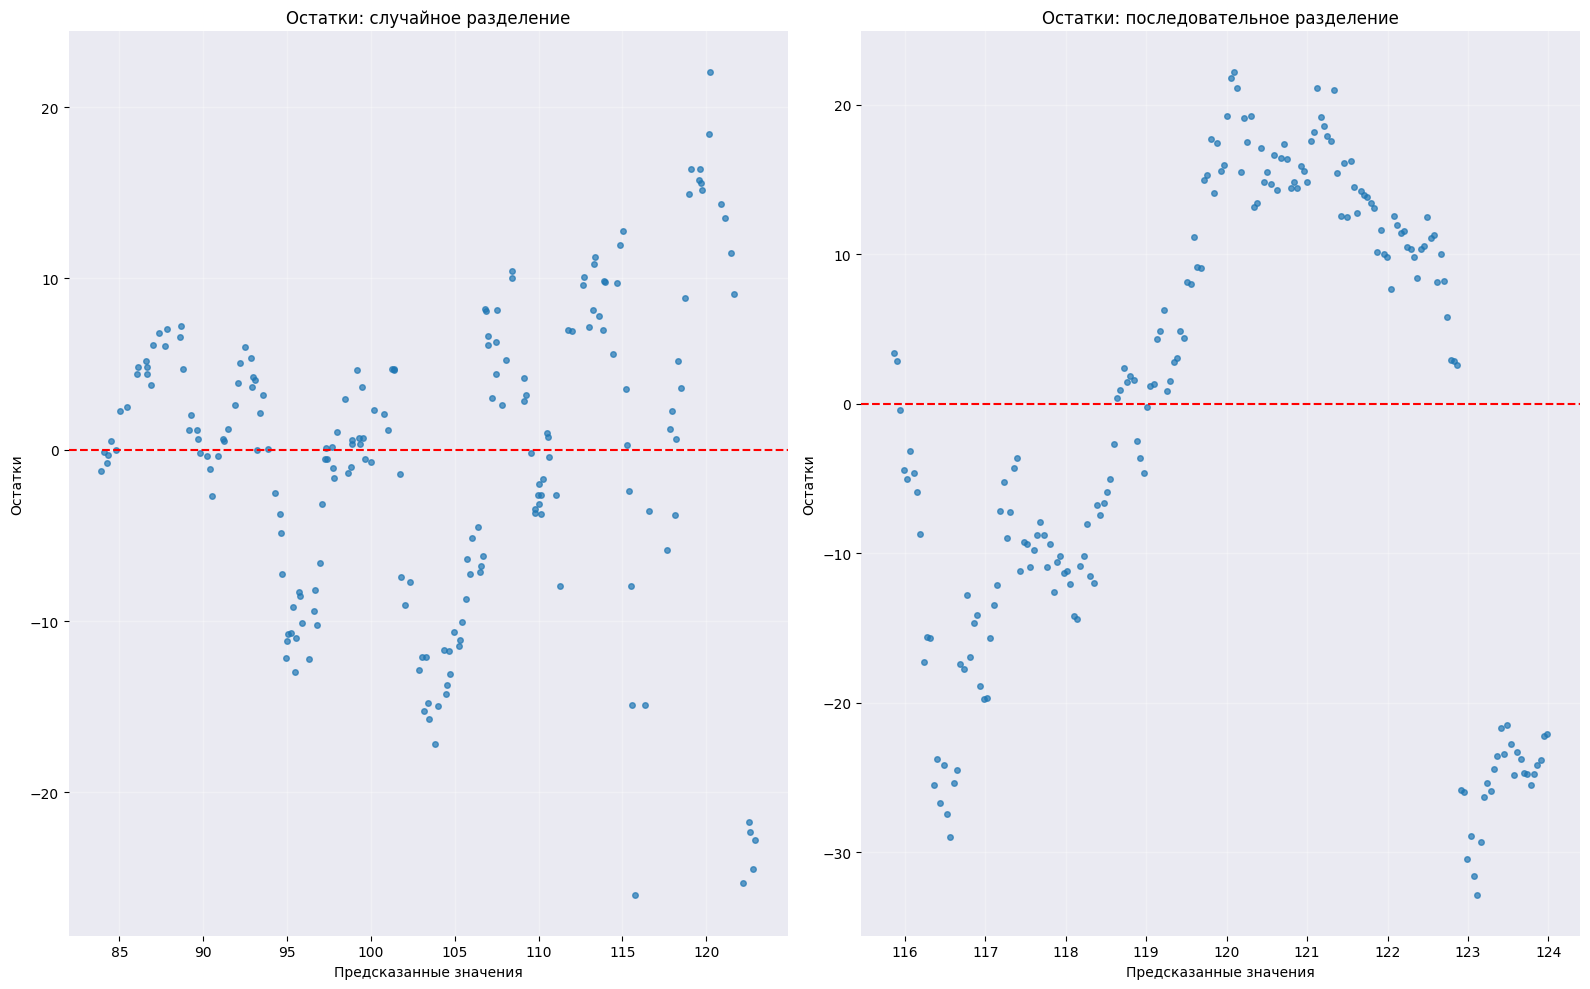

In [111]:
# для случайного
plt.subplot(1, 2, 1)
residuals_random_lin = y_test - y_pred
plt.scatter(y_pred, residuals_random_lin, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Остатки: случайное разделение')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.grid(True, alpha=0.3)

#для последовательного разделения
plt.subplot(1, 2, 2)
residuals_ordered_lin = y_test_ordered - y_pred_ordered
plt.scatter(y_pred_ordered, residuals_ordered_lin, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Остатки: последовательное разделение')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

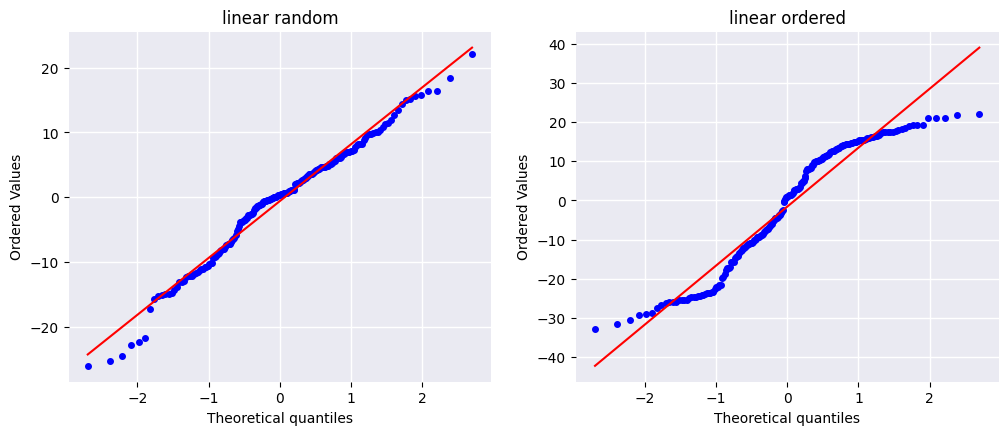

In [114]:
from scipy import stats
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(2,2,1)
stats.probplot(residuals_random_lin,dist="norm",plot=ax1)
plt.title("linear random")
ax2= fig.add_subplot(2,2,2)
stats.probplot(residuals_ordered_lin,dist="norm",plot=ax2)
plt.title("linear ordered")
plt.show()
